In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx 
%matplotlib inline
import time
import torch.nn as nn
import random

cuda = True

In [2]:
train = np.load("./data/loc_train_charged5.npy")

print(train.shape)
print(train[0][:][0][1].shape)

(10000, 49, 2, 5)
(5,)


(5, 2, 49)


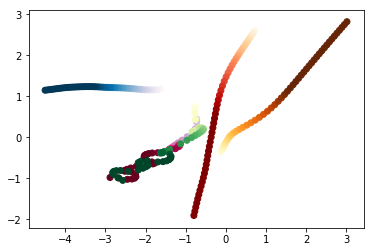

In [3]:
data = train[10]
data = np.transpose(data)
print(data.shape)
maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]
for part in range(5):
    cmap = maps[part](10*np.arange(49))
    plt.scatter(*data[part], c=cmap)

In [4]:
from utils import *
from modules import *

SUFFIX = "_springs5"

train_loader, valid_loader, test_loader, loc_max, loc_min, vel_max, vel_min = load_data(
    64, SUFFIX)



In [5]:
def train(epoch, best_val_loss):
    t = time.time()
    nll_train = []
    acc_train = []
    kl_train = []
    mse_train = []

    model.encoder.train()
    model.decoder.train()
    scheduler.step()
    for batch_idx, (data, relations) in enumerate(train_loader):

        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data), Variable(relations)
        optimizer.zero_grad()

        logits = model.encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=TAU, hard=HARD)
        prob = my_softmax(logits, -1)

        if DECODER_TYPE == 'rnn':
            output = model.decoder(data, edges, rel_rec, rel_send, 100,
                             burn_in=True,
                             burn_in_steps=NUM_TIMESTEPS - PREDICTION_STEPS)
        else:
            output = model.decoder(data, edges, rel_rec, rel_send,
                             PREDICTION_STEPS)

        target = data[:, :, 1:, :]

        loss_nll = nll_gaussian(output, target, VAR)

        if PRIOR:
            loss_kl = kl_categorical(prob, log_prior, NUM_ATOMS)
        else:
            loss_kl = kl_categorical_uniform(prob, NUM_ATOMS,
                                             EDGE_TYPES)

        loss = loss_nll + loss_kl

        acc = edge_accuracy(logits, relations)
        acc_train.append(acc)

        loss.backward()
        optimizer.step()

        mse_train.append(F.mse_loss(output, target).data[0])
        nll_train.append(loss_nll.data[0])
        kl_train.append(loss_kl.data[0])
        
        

    nll_val = []
    acc_val = []
    kl_val = []
    mse_val = []

    model.encoder.eval()
    model.decoder.eval()
    for batch_idx, (data, relations) in enumerate(valid_loader):
        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data, volatile=True), Variable(
            relations, volatile=True)

        logits = model.encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=TAU, hard=True)
        prob = my_softmax(logits, -1)

        # validation output uses teacher forcing
        output = model.decoder(data, edges, rel_rec, rel_send, 1)

        target = data[:, :, 1:, :]
        loss_nll = nll_gaussian(output, target, VAR)
        loss_kl = kl_categorical_uniform(prob, NUM_ATOMS, EDGE_TYPES)

        acc = edge_accuracy(logits, relations)
        acc_val.append(acc)

        mse_val.append(F.mse_loss(output, target).data[0])
        nll_val.append(loss_nll.data[0])
        kl_val.append(loss_kl.data[0])

    print('Epoch: {:04d}'.format(epoch),
          'nll_train: {:.10f}'.format(np.mean(nll_train)),
          'kl_train: {:.10f}'.format(np.mean(kl_train)),
          'mse_train: {:.10f}'.format(np.mean(mse_train)),
          'acc_train: {:.10f}'.format(np.mean(acc_train)),
          'nll_val: {:.10f}'.format(np.mean(nll_val)),
          'kl_val: {:.10f}'.format(np.mean(kl_val)),
          'mse_val: {:.10f}'.format(np.mean(mse_val)),
          'acc_val: {:.10f}'.format(np.mean(acc_val)),
          'time: {:.4f}s'.format(time.time() - t))
    
    return np.mean(nll_val)


def test():
    acc_test = []
    nll_test = []
    kl_test = []
    mse_test = []
    tot_mse = 0
    counter = 0

    model.encoder.eval()
    model.decoder.eval()

    for batch_idx, (data, relations) in enumerate(test_loader):
        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data, volatile=True), Variable(
            relations, volatile=True)

        assert (data.size(2) - NUM_TIMESTEPS) >= NUM_TIMESTEPS

        data_encoder = data[:, :, :NUM_TIMESTEPS, :].contiguous()
        data_decoder = data[:, :, -NUM_TIMESTEPS:, :].contiguous()

        logits = model.encoder(data_encoder, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=TAU, hard=True)

        prob = my_softmax(logits, -1)

        output = model.decoder(data_decoder, edges, rel_rec, rel_send, 1)
        print(output.shape)
        target = data_decoder[:, :, 1:, :]
        loss_nll = nll_gaussian(output, target, VAR)
        loss_kl = kl_categorical_uniform(prob, NUM_ATOMS, EDGE_TYPES)

        acc = edge_accuracy(logits, relations)
        acc_test.append(acc)

        mse_test.append(F.mse_loss(output, target).data[0])
        nll_test.append(loss_nll.data[0])
        kl_test.append(loss_kl.data[0])

        # For plotting purposes
        if DECODER_TYPE == 'rnn':
            if args.dynamic_graph:
                output = model.decoder(data, edges, rel_rec, rel_send, 100,
                                 burn_in=True, burn_in_steps=NUM_TIMESTEPS,
                                 dynamic_graph=True, encoder=model.encoder,
                                 temp=TAU)
            else:
                output = model.decoder(data, edges, rel_rec, rel_send, 100,
                                 burn_in=True, burn_in_steps=NUM_TIMESTEPS)
            output = output[:, :, NUM_TIMESTEPS:, :]
            target = data[:, :, -NUM_TIMESTEPS:, :]
        else:
            data_plot = data[:, :, NUM_TIMESTEPS:NUM_TIMESTEPS + 21,
                        :].contiguous()
            output = model.decoder(data_plot, edges, rel_rec, rel_send, 20)
            target = data_plot[:, :, 1:, :]

        mse = ((target - output) ** 2).mean(dim=0).mean(dim=0).mean(dim=-1)
        tot_mse += mse.data.cpu().numpy()
        counter += 1

    mean_mse = tot_mse / counter
    mse_str = '['
    for mse_step in mean_mse[:-1]:
        mse_str += " {:.12f} ,".format(mse_step)
    mse_str += " {:.12f} ".format(mean_mse[-1])
    mse_str += ']'

    print('--------------------------------')
    print('--------Testing-----------------')
    print('--------------------------------')
    print('nll_test: {:.10f}'.format(np.mean(nll_test)),
          'kl_test: {:.10f}'.format(np.mean(kl_test)),
          'mse_test: {:.10f}'.format(np.mean(mse_test)),
          'acc_test: {:.10f}'.format(np.mean(acc_test)))
    print('MSE: {}'.format(mse_str))
    

In [6]:
NUM_EPOCHS = 10
NUM_TIMESTEPS = 49 
dims = 4 
PREDICTION_STEPS = 10
VAR = 5e-5

PRIOR =False


TAU = Variable(torch.FloatTensor([5]), requires_grad=False).cuda()
HARD = True

NUM_ATOMS = 5
EDGE_TYPES = 2

DECODER_TYPE = "mlp"

# DECODER_TYPE = "rnn"


DECODER_HIDDEN = 256
SKIP_FIRST = False
DECODER_DROPOUT = 0.0

off_diag = np.ones([NUM_ATOMS, NUM_ATOMS]) - np.eye(NUM_ATOMS)

rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)

rel_rec = torch.FloatTensor(rel_rec).cuda()
rel_send = torch.FloatTensor(rel_send).cuda()

In [7]:
# encoder = MLPEncoder(n_in = NUM_TIMESTEPS * 4, n_hid = 256, n_out = 2).cuda()

# decoder = MLPDecoder(n_in_node =4, n_hid = 256, edge_types=2, msg_hid = 256, msg_out=256).cuda()


class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()


        self.encoder = MLPEncoder(n_in = NUM_TIMESTEPS * 4, n_hid = 256, n_out = 2).cuda()
        
        if DECODER_TYPE == "mlp":
            self.decoder = MLPDecoder(n_in_node =4, n_hid = 256, edge_types=2, msg_hid = 256, msg_out=256).cuda()
        elif DECODER_TYPE == "sim":
            self.decoder = SimulationDecoder(loc_max, loc_min, vel_max, vel_min, SUFFIX).cuda()
        else:
            self.decoder = RNNDecoder(n_in_node=dims,
                         edge_types=EDGE_TYPES,
                         n_hid=DECODER_HIDDEN,
                         do_prob=DECODER_DROPOUT,
                         skip_first=SKIP_FIRST).cuda()
        

    def forward(self, x, tau=1, hard = False, n_samples = 1):

        logits = self.encoder(x, rel_rec, rel_send)
        output = []
        for i in range(n_samples):
            edges = gumbel_softmax(logits, tau=TAU, hard=HARD)
            output.append(self.decoder(x, edges, rel_rec, rel_send,PREDICTION_STEPS))

        return output
    
model = GNN()
model

Using factor graph MLP encoder.
Using learned interaction net decoder.


/home/pierre/Documents/DTU/Deep Learning/Project/discrete_flows/GNN/modules.py:27: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)
/home/pierre/Documents/DTU/Deep Learning/Project/discrete_flows/GNN/modules.py:110: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)


GNN(
  (encoder): MLPEncoder(
    (mlp1): MLP(
      (fc1): Linear(in_features=196, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): MLP(
      (fc1): Linear(in_features=512, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): MLP(
      (fc1): Linear(in_features=256, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp4): MLP(
      (fc1): Linear(in_features=768, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

In [8]:
import torch.optim as optim
from torch.optim import lr_scheduler

optimizer = optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=5e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200,gamma=0.5)

In [9]:
t_total = time.time()
best_val_loss = np.inf
best_epoch = 0
for epoch in range(NUM_EPOCHS):
    val_loss = train(epoch, best_val_loss)
    print(TAU)
    TAU = torch.max(TAU * 0.9, torch.FloatTensor([0.5]).cuda())
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
print("Optimization Finished!")
print("Best Epoch: {:04d}".format(best_epoch))



/home/pierre/Documents/DTU/Deep Learning/Project/discrete_flows/GNN/utils.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_max_1d = F.softmax(trans_input)
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWa

Epoch: 0000 nll_train: 4586.0698242188 kl_train: -1.5743626356 mse_train: 0.0023885781 acc_train: 0.4979000796 nll_val: 27.6115856171 kl_val: -0.8963263035 mse_val: 0.0000143810 acc_val: 0.4915820312 time: 16.8929s
tensor([5.], device='cuda:0')
Epoch: 0001 nll_train: 885.7954711914 kl_train: -0.8339093328 mse_train: 0.0004613518 acc_train: 0.4886892914 nll_val: 26.0414047241 kl_val: -0.7753811479 mse_val: 0.0000135632 acc_val: 0.4842773437 time: 15.2077s
tensor([4.5000], device='cuda:0')
Epoch: 0002 nll_train: 790.4114379883 kl_train: -0.8502656221 mse_train: 0.0004116726 acc_train: 0.4661873010 nll_val: 22.0109100342 kl_val: -0.8641646504 mse_val: 0.0000114640 acc_val: 0.4280371094 time: 15.5825s
tensor([4.0500], device='cuda:0')
Epoch: 0003 nll_train: 663.1705932617 kl_train: -0.7988182306 mse_train: 0.0003454014 acc_train: 0.3796775478 nll_val: 17.6932678223 kl_val: -0.7506958246 mse_val: 0.0000092152 acc_val: 0.3435546875 time: 15.3847s
tensor([3.6450], device='cuda:0')
Epoch: 0004

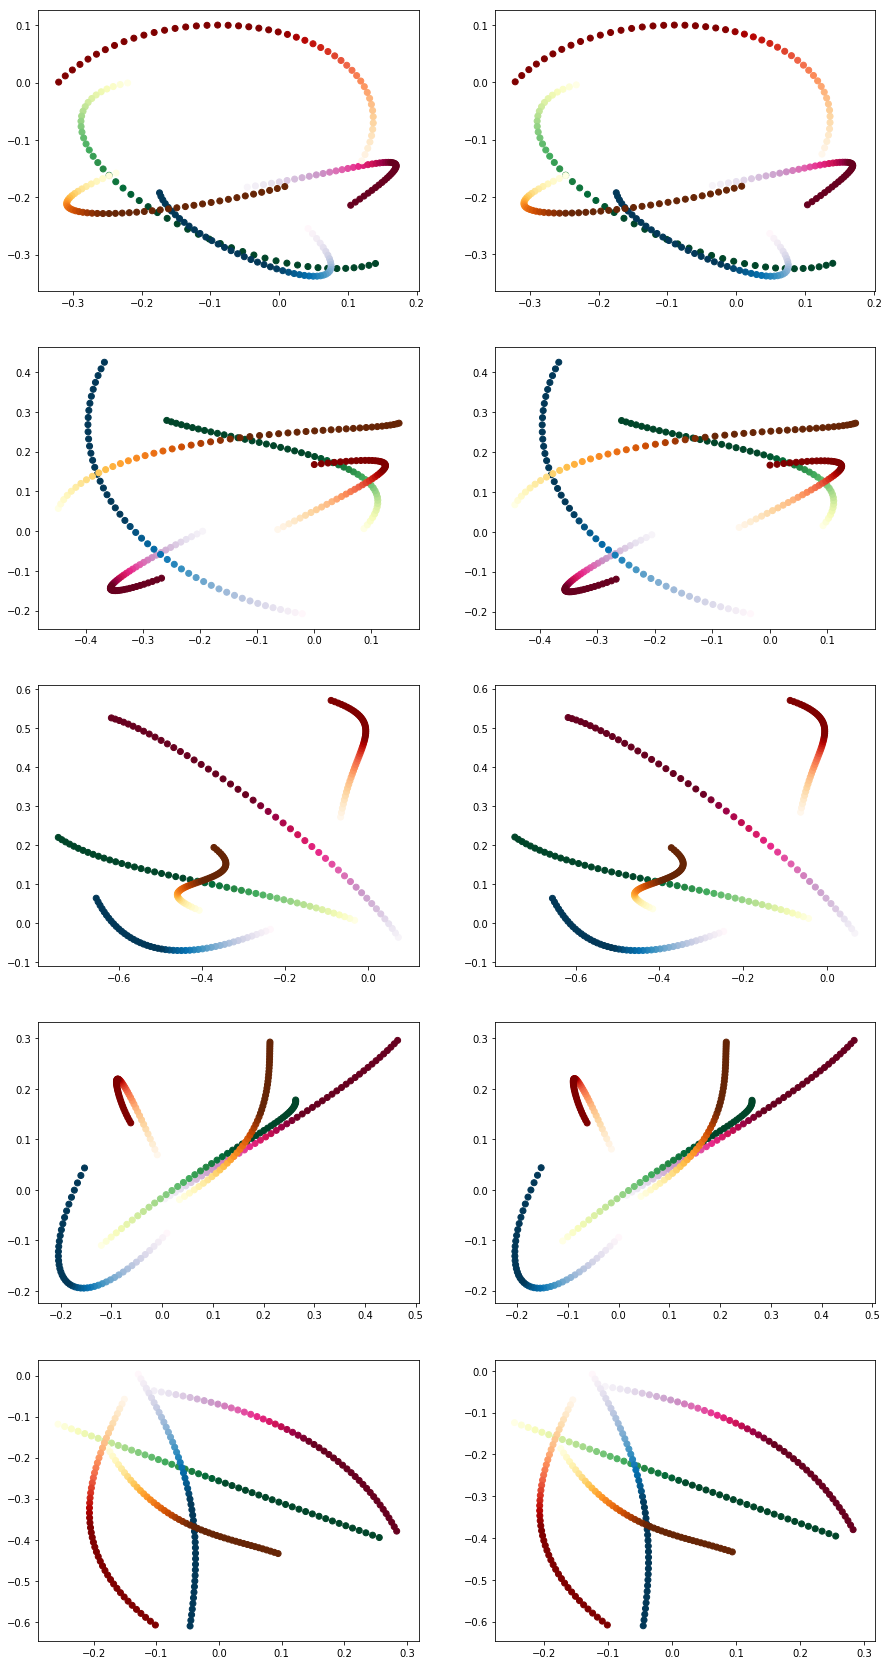

In [10]:
### Prediction of model with right position at each step


f, axarr = plt.subplots(5, 2, figsize=(15, 30))
batch = next(iter(test_loader))[0][0:5]

model.encoder.eval()
model.decoder.eval()

x = batch.narrow(2,0,49).cuda()
logits = model.encoder(x, rel_rec, rel_send)
edges = gumbel_softmax(logits, tau=TAU, hard=HARD)
prediction = model.decoder(x, edges, rel_rec, rel_send,1)


maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

# maps = ['g', 'b', 'k', 'r', 'c']

for i, ax in enumerate(axarr.flat):
    b = torch.transpose(x[i//2], 1,2)
#     print(b.shape)
    if i%2==0:
        for j in range(5):
            cmap = maps[j](10*np.arange(49))
            ax.scatter(b[j][0], b[j][1], c=cmap)
            
#             cmap = maps[j]
#             ax.scatter(b[j][0], b[j][1], c=cmap, alpha=1)
            

    else:
        
        b = torch.transpose(prediction[i//2], 1,2).cpu().detach().numpy()
#         print(b.shape)
        for j in range(5):
            cmap = maps[j](10*np.arange(48))
            ax.scatter(b[j][0], b[j][1], c=cmap)            
#                 cmap = maps[j]
#                 ax.scatter(b[j][0], b[j][1], c=cmap, alpha = 0.05)



    

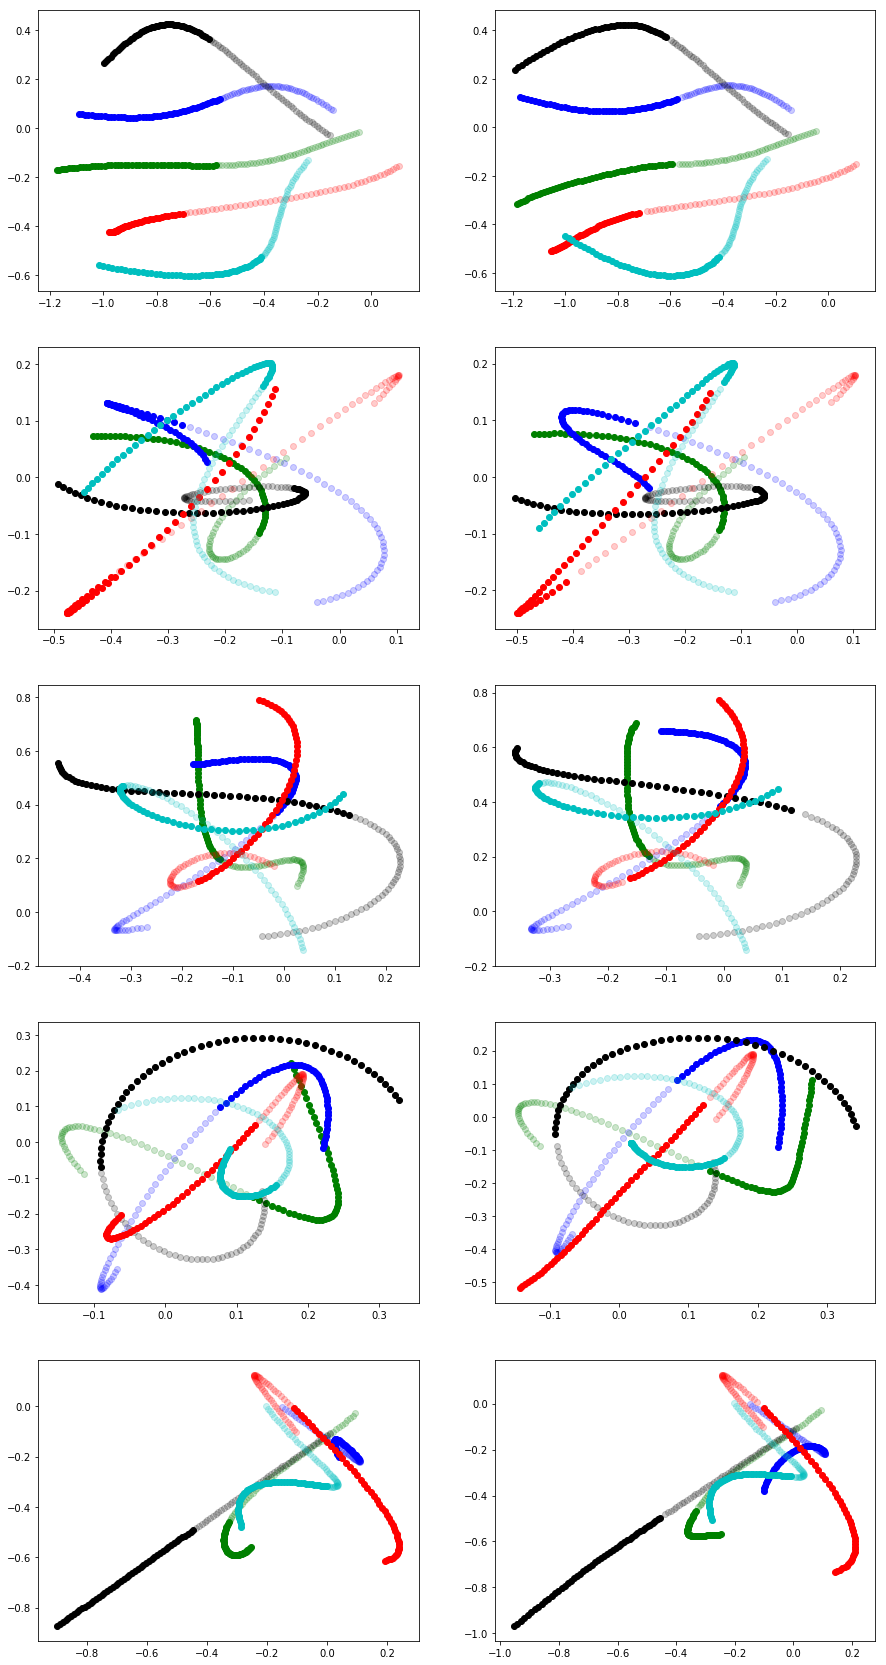

In [11]:
f, axarr = plt.subplots(5, 2, figsize=(15, 30))
batch = next(iter(test_loader))[0][10:15]

model.encoder.eval()
model.decoder.eval()

pred_steps = 50 
BURN_IN = False
BURN_IN_STEPS = 30
DYNAMIC_GRAPH = False


x = batch.narrow(2,0,49).cuda()
logits = model.encoder(x, rel_rec, rel_send)


edges = gumbel_softmax(logits, tau=TAU, hard=HARD)

inputs = batch.transpose(1, 2)


sizes = [edges.size(0), inputs.size(1), edges.size(1),
                 edges.size(2)]
rel_type = edges.unsqueeze(1).expand(sizes)



last_pred = inputs[:, 49::pred_steps, :, :].cuda()
curr_rel_type = rel_type[:, 49::pred_steps, :, :].cuda()
# NOTE: Assumes rel_type is constant (i.e. same across all time steps).


hidden = Variable(torch.zeros(inputs.size(0), inputs.size(2), DECODER_HIDDEN)).cuda()



# Run n prediction steps
preds_list = []
for step in range(0, pred_steps):
    if DECODER_TYPE == "mlp":
        last_pred = model.decoder.single_step_forward(last_pred, rel_rec, rel_send, curr_rel_type)
    elif DECODER_TYPE == "rnn":
        time_steps = inputs.size(1)
        if BURN_IN:
            if step <= BURN_IN_STEPS:
                ins = inputs[:, step, :, :]
            else:
                ins = preds_list[step - 1]
        else:
            assert (pred_steps <= time_steps)
            # Use ground truth trajectory input vs. last prediction
            if not step % pred_steps:
                ins = inputs[:, 49+step, :, :]
            else:
                ins = preds_list[step - 1]

        if DYNAMIC_GRAPH and step >= BURN_IN_STEPS:
            # NOTE: Assumes burn_in_steps = args.timesteps
            logits = model.encoder(
                data[:, :, step - burn_in_steps:step, :].contiguous(),
                rel_rec, rel_send)
            rel_type = gumbel_softmax(logits, tau=temp, hard=True)

        last_pred, hidden = model.decoder.single_step_forward(ins.cuda(), rel_rec, rel_send,
                                                rel_type[:,0,:,:], hidden)

    preds_list.append(last_pred)
if DECODER_TYPE == "rnn":
    
    preds = torch.stack(preds_list, dim=1)

    sizes = [preds.size(0), preds.size(2), preds.size(1), preds.size(3)]
    output = Variable(torch.zeros(sizes)).cuda()
    output = preds.transpose(1,2)
elif DECODER_TYPE == "mlp":
    sizes = [preds_list[0].size(0), preds_list[0].size(1) * pred_steps, preds_list[0].size(2), preds_list[0].size(3)]
    output = Variable(torch.zeros(sizes)).cuda()

    for i in range(len(preds_list)):
        output[:, i::pred_steps, :, :] = preds_list[i]

    output = output.transpose(1,2)


# maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

maps = ['g', 'b', 'k', 'r', 'c']


for i, ax in enumerate(axarr.flat):
    b = torch.transpose(batch[i//2], 1,2)
#     print(b.shape)
    if i%2==0:
        for j in range(5):
#             cmap = maps[j](10*np.arange(49))
#             ax.scatter(b[j][0], b[j][1], c=cmap)
            
            cmap = maps[j]
            ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
            ax.scatter(b[j][0][49:], b[j][1][49:], c=cmap, alpha = 1)
            

    else:
        
        b = torch.transpose(batch[i//2], 1,2).cpu().detach().numpy()
        d = torch.transpose(output[i//2], 1,2).cpu().detach().numpy()

        for j in range(5):
#             cmap = maps[j](10*np.arange(48))
#             ax.scatter(b[j][0], b[j][1], c=cmap)  

            cmap = maps[j]
            ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
            ax.scatter(d[j][0], d[j][1], c=cmap, alpha = 1)



    

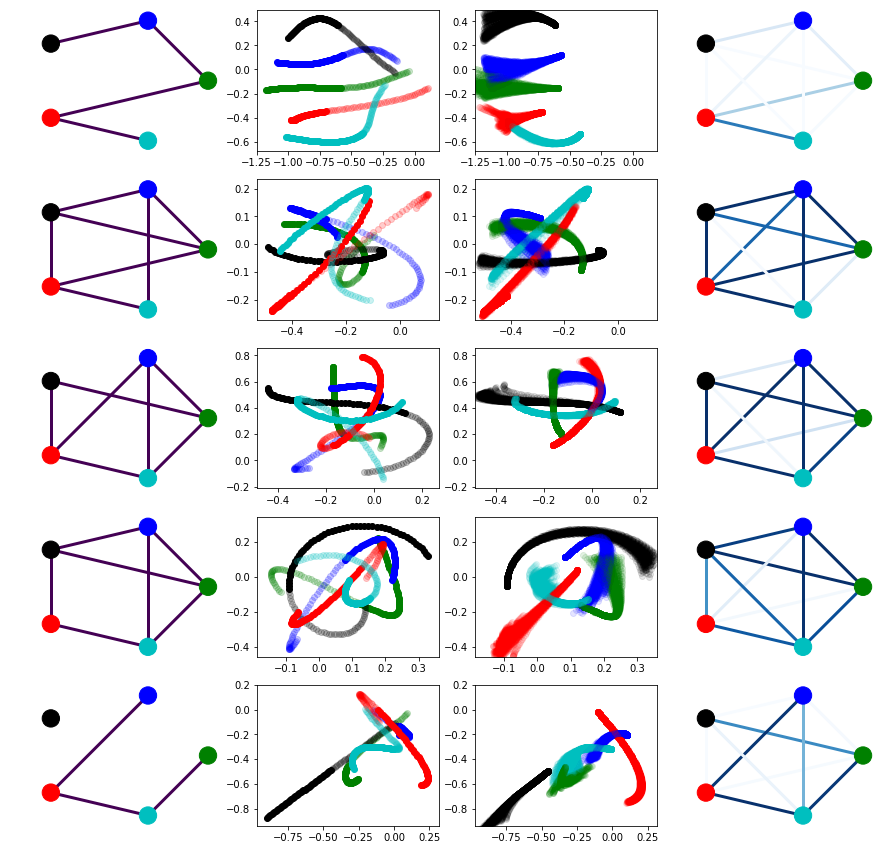

In [25]:
if DECODER_TYPE== "mlp":
    f, axarr = plt.subplots(5, 4, figsize=(15, 15))
    batch_complete_data = next(iter(test_loader))
    batch = batch_complete_data[0][10:15]
    edges_b = batch_complete_data[1][10:15]
    batch_edges = edges_b.view((5,5,4)).numpy()

    model.encoder.eval()
    model.decoder.eval()

    pred_steps = 50 

    n_samples = 50

    x = batch.narrow(2,0,49).cuda()
    # logits = torch.clamp(model.encoder(x, rel_rec, rel_send),0.1,0.9)
    logits = model.encoder(x, rel_rec, rel_send)


    inputs = batch.transpose(1, 2)
    outputs_list = []
    edges_samples = []
    for sample in range(n_samples):
    #     edges = torch.clamp(gumbel_softmax(logits, tau=TAU, hard=HARD),0.2,0.8)
        edges = gumbel_softmax(logits, tau=TAU, hard=False)

        sizes = [edges.size(0), inputs.size(1), edges.size(1),
                     edges.size(2)]
        rel_type = edges.unsqueeze(1).expand(sizes)



        last_pred = inputs[:, 49::pred_steps, :, :].cuda()
        curr_rel_type = rel_type[:, 49::pred_steps, :, :].cuda()
        # NOTE: Assumes rel_type is constant (i.e. same across all time steps).


        # Run n prediction steps
        preds = []
        for step in range(0, pred_steps):
            last_pred = model.decoder.single_step_forward(last_pred, rel_rec, rel_send, curr_rel_type)
            preds.append(last_pred)
            
        sizes = [preds[0].size(0), preds[0].size(1) * pred_steps, preds[0].size(2), preds[0].size(3)]

        output = Variable(torch.zeros(sizes))
        if inputs.is_cuda:
            output = output.cuda()

        for i in range(len(preds)):
            output[:, i::pred_steps, :, :] = preds[i]

        output = output.transpose(1,2)
        outputs_list.append(output.cpu().detach())
        edges_samples.append(edges.cpu().detach())

    # maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

    maps = ['g', 'b', 'k', 'r', 'c']

    x_lim = []
    y_lim = []


    for i, ax in enumerate(axarr.flat):
        b = torch.transpose(batch[i//4], 1,2)
    #     print(b.shape)
        if i%4 ==0:

            edges_list = []

            for k,part in enumerate(batch_edges[i//4]):
                l = np.insert(part,k,0)
                edges_list.append(np.array(l))

            edges_list = np.array(edges_list)

            graph = nx.Graph()
            if SUFFIX == "_springs5":
                graph = nx.from_numpy_matrix(edges_list)
                type_edges = [edges_list[a][b] for (a,b) in graph.edges()]
                nx.draw(graph,
                        ax=ax, 
                        pos=nx.shell_layout(graph),
                        node_color=maps, 
                        edge_color=type_edges,
                        width = 3)
            elif SUFFIX == "_charged5":
                edges_list[edges_list == 0] = -1
                edges_list = edges_list + np.eye(edges_list.shape[0])
                graph = nx.from_numpy_matrix(edges_list)
                type_edges = [edges_list[a][b] for (a,b) in graph.edges()]

                nx.draw(graph,
                        ax=ax, 
                        pos=nx.shell_layout(graph),
                        node_color=maps,
                        edge_cmap=cm.bwr, 
                        edge_color=type_edges,
                        width = 3)

        elif i%4==1:
            for j in range(5):
                cmap = maps[j]
                ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
                ax.scatter(b[j][0][49:], b[j][1][49:], c=cmap, alpha = 1)
                x_lim = ax.get_xlim()
                y_lim = ax.get_ylim()


        elif i%4==2:

            b = torch.transpose(batch[i//4], 1,2).cpu().detach().numpy()
            for j in range(5):
                cmap = maps[j]
                #ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
            for output in outputs_list:
                d = torch.transpose(output[i//4], 1,2).numpy()
                for j in range(5):
                    cmap = maps[j]
                    ax.scatter(d[j][0], d[j][1], c=cmap, alpha = 0.1)
                    ax.set_xlim(x_lim)
                    ax.set_ylim(y_lim) 
        else:
            edges_list = []
            resized_edges = edges_samples[random.randint(0,n_samples-1)].narrow(-1,0,1) #show the graph of a random sample
            for k,part in enumerate(resized_edges.view(5,5,4,-1).numpy()[i//4]):
                l = np.insert(part,k,0)
                edges_list.append(np.array(l))

            edges_list = np.array(edges_list)
            if SUFFIX == "_springs5":
                graph = nx.Graph()
                graph = nx.from_numpy_matrix(edges_list)
                proba_edges = [edges_list[a][b] for (a,b) in graph.edges()]
                nx.draw(graph, 
                        ax=ax, 
                        pos=nx.shell_layout(graph), 
                        node_color=maps, 
                        edge_cmap=cm.Blues, 
                        edge_color=proba_edges,
                        edge_vmin=0, 
                        edge_vmax=1,
                        width = 3)
            else:
                graph = nx.Graph()
                edges_list[edges_list == 0] = 1e-5
                edges_list = edges_list + np.eye(edges_list.shape[0])

                graph = nx.from_numpy_matrix(edges_list)
                proba_edges = [edges_list[a][b] for (a,b) in graph.edges()]

                nx.draw(graph, 
                        ax=ax, 
                        pos=nx.shell_layout(graph), 
                        node_color=maps, 
                        edge_cmap=cm.bwr, 
                        edge_vmin=0, 
                        edge_vmax=1,
                        edge_color=proba_edges,
                        width = 3)





In [13]:
if DECODER_TYPE== "rnn":
    f, axarr = plt.subplots(5, 4, figsize=(15, 15))
    batch_complete_data = next(iter(test_loader))
    batch = batch_complete_data[0][10:15]
    edges_b = batch_complete_data[1][10:15]
    batch_edges = edges_b.view((5,5,4)).numpy()

    model.encoder.eval()
    model.decoder.eval()

    pred_steps = 50 

    n_samples = 50

    x = batch.narrow(2,0,49).cuda()
    # logits = torch.clamp(model.encoder(x, rel_rec, rel_send),0.1,0.9)
    logits = model.encoder(x, rel_rec, rel_send)


    inputs = batch.transpose(1, 2)
    outputs_list = []
    edges_samples = []
    for sample in range(n_samples):
    #     edges = torch.clamp(gumbel_softmax(logits, tau=TAU, hard=HARD),0.2,0.8)
        edges = gumbel_softmax(logits, tau=TAU, hard=HARD)

        sizes = [edges.size(0), inputs.size(1), edges.size(1),
                     edges.size(2)]
        
        
              
        rel_type = edges.unsqueeze(1).expand(sizes)

        hidden = Variable(torch.zeros(inputs.size(0), inputs.size(2), DECODER_HIDDEN)).cuda()

        last_pred = inputs[:, 49::pred_steps, :, :].cuda()
        curr_rel_type = rel_type[:, 49::pred_steps, :, :].cuda()
        # NOTE: Assumes rel_type is constant (i.e. same across all time steps).


        # Run n prediction steps
        preds = []
        for step in range(0, pred_steps):
            time_steps = inputs.size(1)
            if BURN_IN:
                if step <= BURN_IN_STEPS:
                    ins = inputs[:, step, :, :]
                else:
                    
                    ins = preds[step - 1]
            else:
                assert (pred_steps <= time_steps)
                # Use ground truth trajectory input vs. last prediction
                if not step % pred_steps:
                    ins = inputs[:, 49+step, :, :]
                else:
                    ins = preds[step - 1]

            if DYNAMIC_GRAPH and step >= BURN_IN_STEPS:
                # NOTE: Assumes burn_in_steps = args.timesteps
                logits = model.encoder(
                    data[:, :, step - burn_in_steps:step, :].contiguous(),
                    rel_rec, rel_send)
                rel_type = gumbel_softmax(logits, tau=temp, hard=False)

            last_pred, hidden = model.decoder.single_step_forward(ins.cuda(), rel_rec, rel_send,
                                                rel_type[:,0,:,:], hidden)
            preds.append(last_pred)

        
  
        sizes = [preds[0].size(0), pred_steps, preds[0].size(1), preds[0].size(2)]

        output = Variable(torch.zeros(sizes))
        if inputs.is_cuda:
            output = output.cuda()

        for i in range(len(preds)):
            output[:, i::pred_steps, :, :] = preds[i].unsqueeze_(1)

        output = output.transpose(1,2)
        outputs_list.append(output.cpu().detach())
        edges_samples.append(edges.cpu().detach())

    # maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

    maps = ['g', 'b', 'k', 'r', 'c']

    x_lim = []
    y_lim = []


    for i, ax in enumerate(axarr.flat):
        b = torch.transpose(batch[i//4], 1,2)
    #     print(b.shape)
        if i%4 ==0:

            edges_list = []

            for k,part in enumerate(batch_edges[i//4]):
                l = np.insert(part,k,0)
                edges_list.append(np.array(l))

            edges_list = np.array(edges_list)

            graph = nx.Graph()
            if SUFFIX == "_springs5":
                graph = nx.from_numpy_matrix(edges_list)
                type_edges = [edges_list[a][b] for (a,b) in graph.edges()]
                nx.draw(graph,
                        ax=ax, 
                        pos=nx.shell_layout(graph),
                        node_color=maps, 
                        edge_color=type_edges,
                        width = 3)
            elif SUFFIX == "_charged5":
                edges_list[edges_list == 0] = -1
                edges_list = edges_list + np.eye(edges_list.shape[0])
                graph = nx.from_numpy_matrix(edges_list)
                type_edges = [edges_list[a][b] for (a,b) in graph.edges()]

                nx.draw(graph,
                        ax=ax, 
                        pos=nx.shell_layout(graph),
                        node_color=maps,
                        edge_cmap=cm.bwr, 
                        edge_color=type_edges,
                        width = 3)

        elif i%4==1:
            for j in range(5):
                cmap = maps[j]
                ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
                ax.scatter(b[j][0][49:], b[j][1][49:], c=cmap, alpha = 1)
                x_lim = ax.get_xlim()
                y_lim = ax.get_ylim()


        elif i%4==2:

            b = torch.transpose(batch[i//4], 1,2).cpu().detach().numpy()
            for j in range(5):
                cmap = maps[j]
                #ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
            for output in outputs_list:
                d = torch.transpose(output[i//4], 1,2).numpy()
                for j in range(5):
                    cmap = maps[j]
                    ax.scatter(d[j][0], d[j][1], c=cmap, alpha = 0.1)
                    ax.set_xlim(x_lim)
                    ax.set_ylim(y_lim) 
        else:
            edges_list = []
            resized_edges = edges_samples[random.randint(0,n_samples-1)].narrow(-1,0,1) #show the graph of a random sample
            for k,part in enumerate(resized_edges.view(5,5,4,-1).numpy()[i//4]):
                l = np.insert(part,k,0)
                edges_list.append(np.array(l))

            edges_list = np.array(edges_list)
            if SUFFIX == "_springs5":
                graph = nx.Graph()
                graph = nx.from_numpy_matrix(edges_list)
                proba_edges = [edges_list[a][b] for (a,b) in graph.edges()]
                nx.draw(graph, 
                        ax=ax, 
                        pos=nx.shell_layout(graph), 
                        node_color=maps, 
                        edge_cmap=cm.Blues, 
                        edge_color=proba_edges,
                        edge_vmin=0, 
                        edge_vmax=1,
                        width = 3)
            else:
                graph = nx.Graph()
                edges_list[edges_list == 0] = 1e-5
                edges_list = edges_list + np.eye(edges_list.shape[0])

                graph = nx.from_numpy_matrix(edges_list)
                proba_edges = [edges_list[a][b] for (a,b) in graph.edges()]

                nx.draw(graph, 
                        ax=ax, 
                        pos=nx.shell_layout(graph), 
                        node_color=maps, 
                        edge_cmap=cm.bwr, 
                        edge_vmin=0, 
                        edge_vmax=1,
                        edge_color=proba_edges,
                        width = 3)





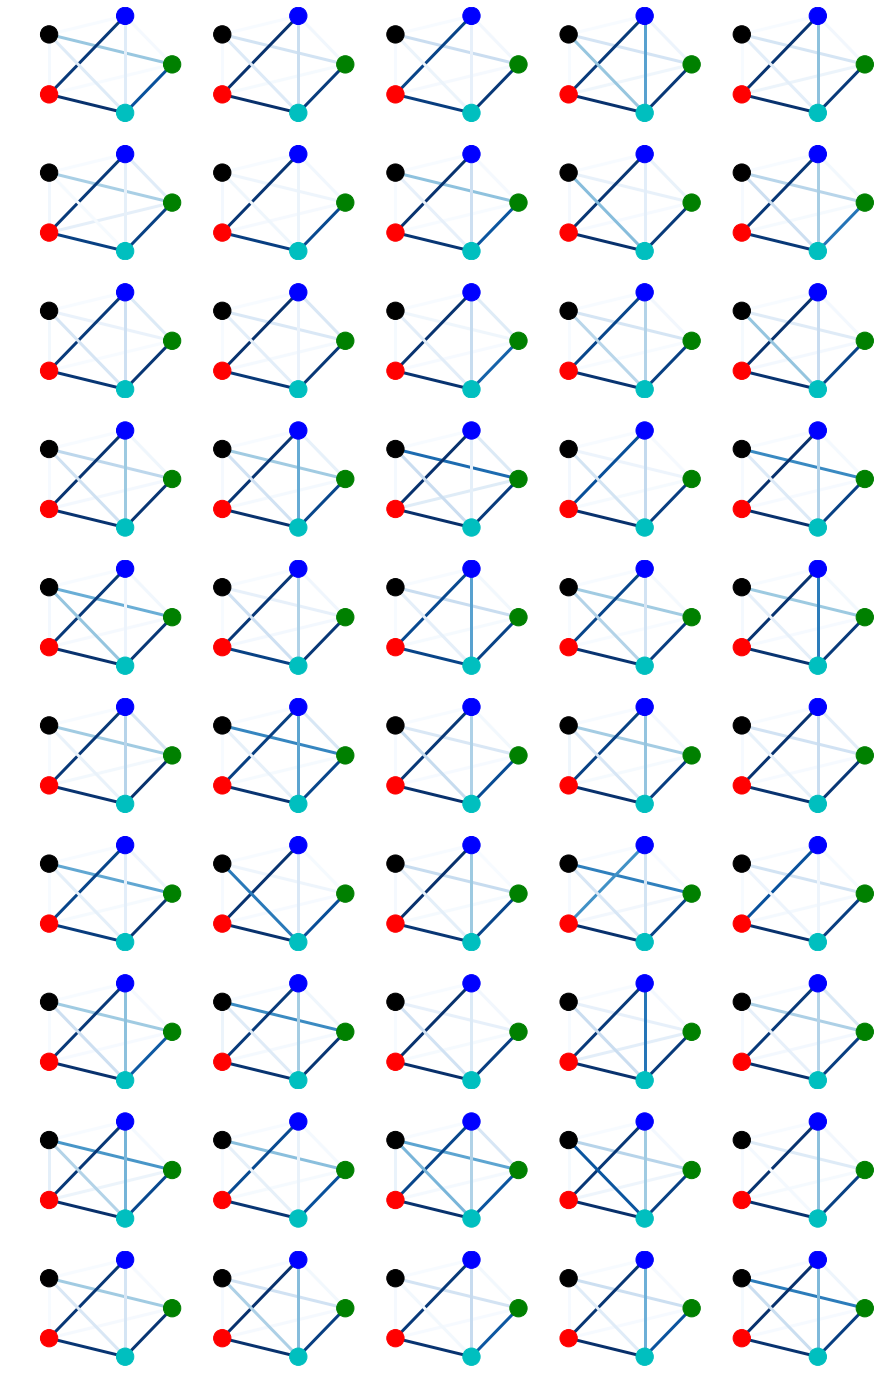

In [26]:
edges_samples = []

for sample in range(n_samples):
    edges = gumbel_softmax(logits, tau=TAU, hard=False)

    edges_samples.append(edges.cpu().detach())


f, axarr = plt.subplots(10, 5, figsize=(15, 25))
for i, ax in enumerate(axarr.flat):
    
    edges_list = []
    resized_edges = edges_samples[i].narrow(-1,0,1) #show the graph of a random sample
    for k,part in enumerate(resized_edges.view(5,5,4,-1).numpy()[4]):
        l = np.insert(part,k,0)
        edges_list.append(np.array(l))
    edges_list = np.array(edges_list)
    graph = nx.Graph()
    edges_list[edges_list == 0] = 1e-5
    edges_list = edges_list + np.eye(edges_list.shape[0])
#     print(edges_list)
    graph = nx.from_numpy_matrix(edges_list)
    proba_edges = [edges_list[a][b] for (a,b) in graph.edges()]
#     print(proba_edges)
    if SUFFIX == "_springs5":
        graph = nx.Graph()
        graph = nx.from_numpy_matrix(edges_list)
        proba_edges = [edges_list[a][b] for (a,b) in graph.edges()]
        nx.draw(graph, 
                ax=ax, 
                pos=nx.shell_layout(graph), 
                node_color=maps, 
                edge_cmap=cm.Blues, 
                edge_color=proba_edges,
                edge_vmin=0, 
                edge_vmax=1,
                width = 3)
    else:
        graph = nx.Graph()
        edges_list[edges_list == 0] = 1e-5
        edges_list = edges_list + np.eye(edges_list.shape[0])

        graph = nx.from_numpy_matrix(edges_list)
        proba_edges = [edges_list[a][b] for (a,b) in graph.edges()]

        nx.draw(graph, 
                ax=ax, 
                pos=nx.shell_layout(graph), 
                node_color=maps, 
                edge_cmap=cm.bwr, 
                edge_vmin=0, 
                edge_vmax=1,
                edge_color=proba_edges,
                width = 3)